# Аналитика в Яндекс.Афише

### Описание
Имеются данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

### Задача проекта
Изучить:
- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

### Описание данных
Таблица **visits** (лог сервера с информацией о посещениях сайта):

- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь

Таблица **orders** (информация о заказах):
- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа

Таблица **costs** (информация о затратах на маркетинг):
- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from imp import reload
plt=reload(plt)

## 1. Обзор данных

*Изучаем данные, их структуру и определяем, что нуждается в предобработке*

In [76]:
visits = pd.read_csv('/datasets/visits_log.csv')
print('Таблица с информацией о посещениях с сайта')
display(visits)
print(visits.info())

Таблица с информацией о посещениях с сайта


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None


In [77]:
orders = pd.read_csv('/datasets/orders_log.csv')
print('Таблица с информацией о покупках с сайта')
display(orders)
print(orders.info())

Таблица с информацией о покупках с сайта


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None


In [78]:
costs = pd.read_csv('/datasets/costs.csv')
print('Таблица с информацией о затратах на маркетинг')
display(costs)
print(costs.info())


Таблица с информацией о затратах на маркетинг


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None


## 1. Вывод 
 - пропуски отсутвуют
 - необходимо привести названия столбцов к нижнему регистру
 - необходимо заменить тип данных в столбцах с датой на datetime

## 2. Предобработка данных

In [79]:
#приводим названия столбцов к стандартному виду
visits.columns = ['device','end_ts','source_id','start_ts','uid']
orders.columns = ['buy_ts', 'revenue', 'uid']

In [80]:
#меняем тип данных с датами на datetime
visits['end_ts'] = pd.to_datetime(visits['end_ts'],format='%Y-%m-%d %H:%M:%S')
visits['start_ts'] = pd.to_datetime(visits['start_ts'],format='%Y-%m-%d %H:%M:%S')

## 3. Подготовка данных

In [81]:
#добавляем столбцы с датой, в которых не будет времени
visits['end_day'] = visits['end_ts'].astype('datetime64[D]')
visits['start_day'] = visits['start_ts'].astype('datetime64[D]')
orders['buy_day'] = orders['buy_ts'].astype('datetime64[D]')
costs['dt_day'] = costs['dt'].astype('datetime64[D]')

## 4. Анализ данных

### 4.1 Продукт
*Исследуем метрики DAU,WAU,MAU, количество и длительность сессий.Определяем, как часто пользователи возвращаются на сайт*

,Пользователей в среднем,Количество
0,В день,907
1,В неделю,5716
2,В месяц,23228


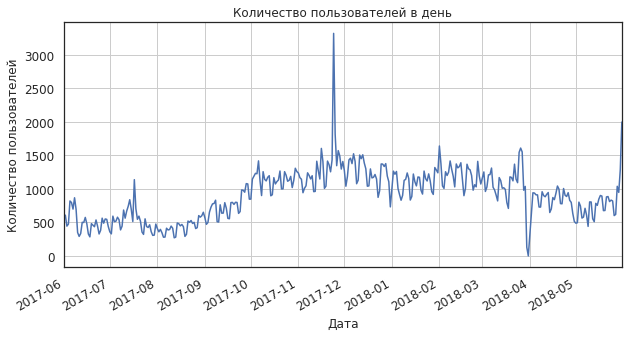

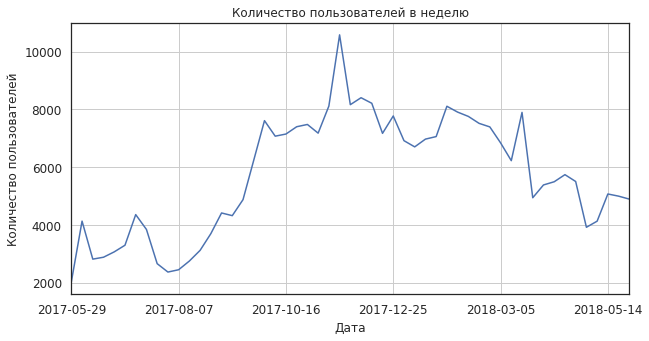

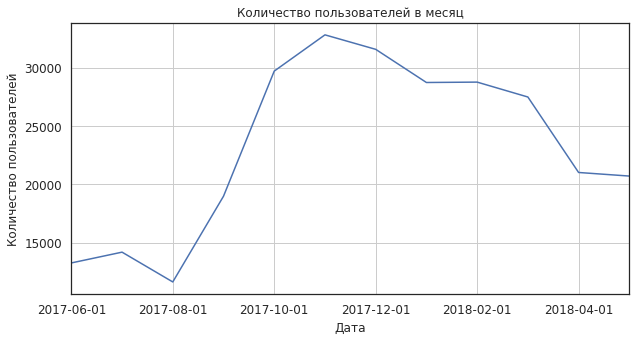

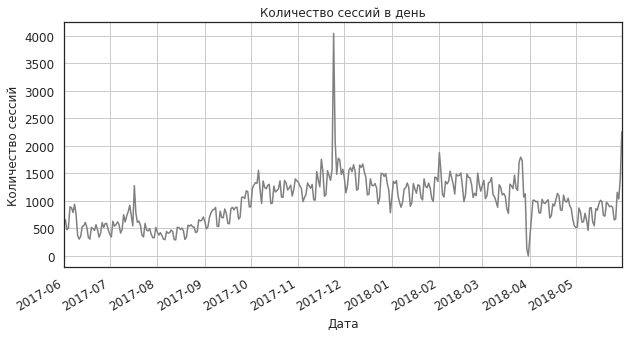

В среднем сессий в день:  987


In [82]:
#исследуем среднее количество пользователей
visits['start_week'] = pd.to_datetime(visits['start_day'],unit='d')- pd.to_timedelta(visits['start_day'].dt.dayofweek, unit='d')
visits['start_week'] = visits['start_week'].dt.strftime('%Y-%m-%d')
visits['start_month'] = visits['start_day'].astype('datetime64[M]').dt.strftime('%Y-%m-%d')
lis = []
for i in range(len(data)):
    lis.append(visits.groupby(data[i]).agg({'uid':'nunique'}).mean().astype('int'))
quantity_day_session = visits.groupby('start_day').agg({'uid':'count'})
product_results = pd.DataFrame({'Пользователей в среднем':['В день','В неделю','В месяц'], 
                                'Количество': [lis[0][0],lis[1][0],lis[2][0]]})
display(product_results)
data = ['start_day','start_week','start_month']
names = ['в день','в неделю', 'в месяц']
for i in range(len(data)):
    visits.groupby(data[i]).agg({'uid':'nunique'}).plot(figsize = (10,5), grid = True,legend = False)
    plt.title('Количество пользователей {}'.format(names[i]),fontsize = 12)
    plt.ylabel('Количество пользователей',fontsize = 12)
    plt.xlabel('Дата',fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.show()
quantity_day_session.plot( figsize = (10,5), grid = True,color = 'grey', legend = False)
plt.title('Количество сессий в день',fontsize = 12)
plt.xlabel('Дата',fontsize = 12)
plt.ylabel('Количество сессий',fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()
print('В среднем сессий в день:  {}'.format(quantity_day_session['uid'].mean().astype('int')))

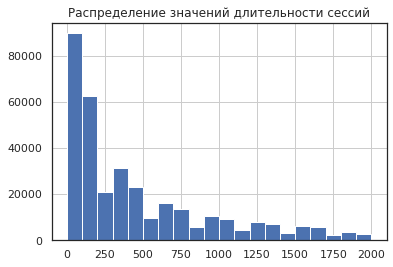

In [83]:
#определяем длину сессии и строим гистограмму распредения
visits['duration'] = ((visits['end_ts']-visits['start_ts'])/np.timedelta64(1,'s')).astype('int')
plt.title('Распределение значений длительности сессий')
visits['duration'].hist(bins=20, range = (0,2000))
plt.show()

Получившееся распределение не является нормальным, поэтому будем использовать метод `.mode()`, определяюий наиболее часто встречающееся значение длительности сессии

In [84]:
print('Режим объекта серии из длительностей сессии:')
print(visits['duration'].mode())

Режим объекта серии из длительностей сессии:
0    60
dtype: int64


In [85]:
def return_visits(visits):
    return_visits = visits.groupby('uid').agg({'start_day':'count'}).reset_index()
    count_return = 0
    for i in range(len(return_visits)):
        if return_visits['start_day'][i]>1:
            count_return += 1
    return count_return/(len(return_visits))
print('Процент вернувшихся на сайт пользователей: {:.1%}'.format(return_visits(visits)))

Процент вернувшихся на сайт пользователей: 22.8%


### 4.1 Вывод

- В день сайтом в среднем пользутеся **907** человек, при этом количество сессий равно **987**, что говорит о том, что очень малая часть пользователей заходит на сайт повторно в этот же день
- В неделю в среднем **5716** человек, в месяц **23228** 
- После первого визита на сайт, повторно возвращается только **22.8%** седи всех пользователей, что говорит о большом потоке незаинтересовавшихся пользователей после первого визита

### 4.2 Продажи
*Исследуем, когда люди начинают  покупать, сколько раз покупают за период, каков средний чек. Определяем сколько денег приносят пользователи компании Яндекс.Афиши с помощью показателя LTV*

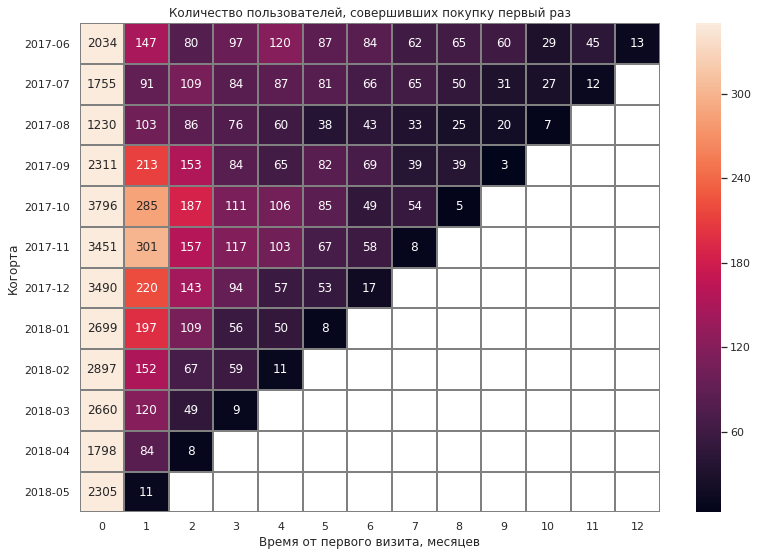

In [86]:
#определяем через какое время после первого визита пользователи начинают покупать
first_start_day = visits.groupby('uid').agg({'start_day':'min'}).reset_index()#ищем дату первого визита
first_start_day.columns = ['uid','first_start_day']

first_order = orders.groupby('uid').agg({'buy_day':'min'}).reset_index()#ищем дату первой покупки
first_order.columns = ['uid','first_buy_date']

visits_and_orders = first_start_day.merge(first_order, on = 'uid')
visits_and_orders['from_visit_to_buy'] = round((visits_and_orders['first_buy_date'] - visits_and_orders['first_start_day'])/np.\
timedelta64(1,'M')).astype('int')#определяем время от первого визита до первой покупки в месяцах
visits_and_orders['first_start_month'] = visits_and_orders['first_start_day'].astype('datetime64[M]').dt.strftime('%Y-%m')
cohorts_buy_date = visits_and_orders.pivot_table(index = 'first_start_month', 
                                                 columns = 'from_visit_to_buy', 
                                                 values = 'uid', 
                                                 aggfunc= 'count')       
plt.figure(figsize=(13, 9))
sns.heatmap(cohorts_buy_date,annot=True,fmt='.0f', linewidths=1,linecolor='gray', vmax=350)
plt.title('Количество пользователей, совершивших покупку первый раз')
plt.xlabel('Время от первого визита, месяцев')
plt.ylabel('Когорта')
plt.show()

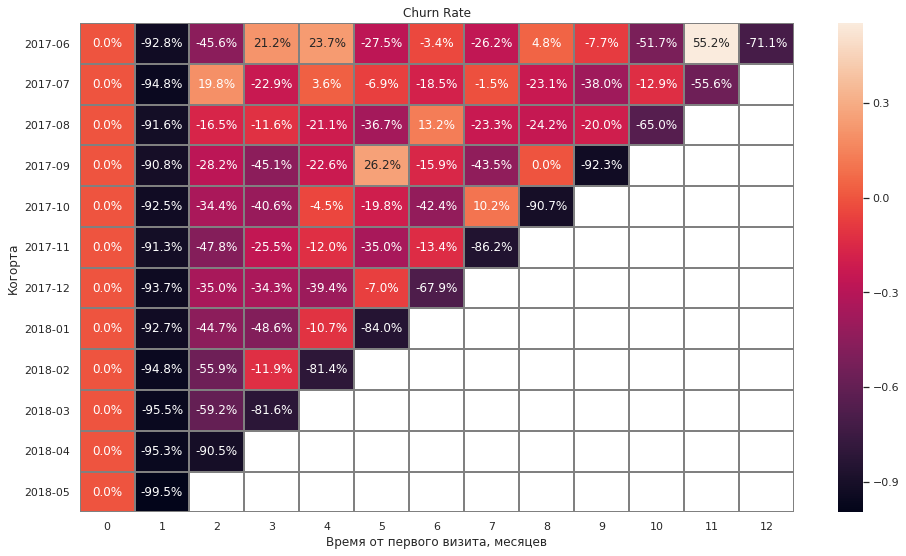

In [87]:
#ищем churn rate
cohorts = visits_and_orders.groupby(['first_start_month','from_visit_to_buy']).agg({'uid':'nunique'}).reset_index()
cohorts['churn_rate'] = cohorts.groupby(['first_start_month'])['uid'].pct_change()
churn_pivot = cohorts.pivot_table(index='first_start_month',
                                            columns='from_visit_to_buy',
                                            values='churn_rate',
                                            aggfunc='sum')
sns.set(style='white')
plt.figure(figsize=(16, 9))
plt.title('Churn Rate')
sns.heatmap(churn_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray')
plt.xlabel('Время от первого визита, месяцев')
plt.ylabel('Когорта')
plt.show()

In [88]:
#ищем коэффициент удержания Retention rate
initial_users_count = cohorts[cohorts['from_visit_to_buy'] == 0][['first_start_month','uid']]
initial_users_count = initial_users_count.rename(columns = {'uid':'cohort_users'})
cohorts = cohorts.merge(initial_users_count, on = 'first_start_month')
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

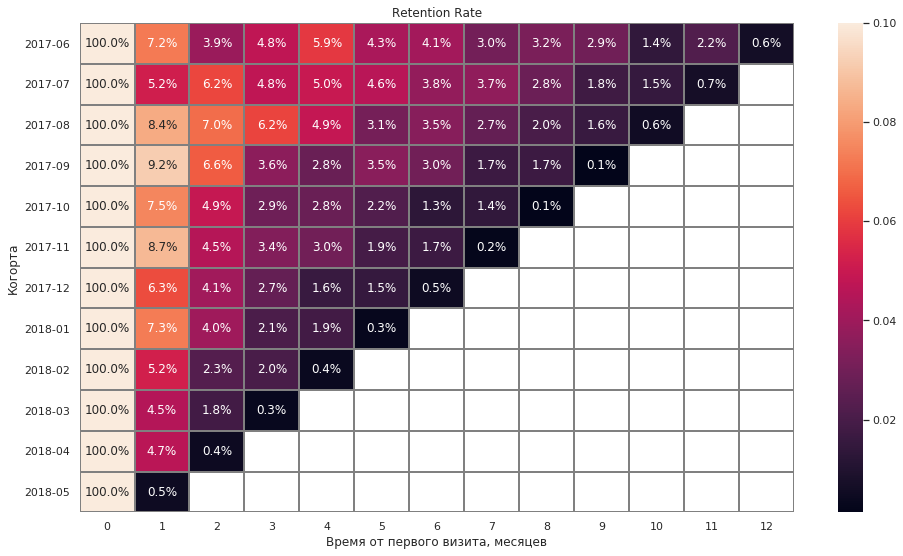

In [89]:
retention_pivot = cohorts.pivot_table(index='first_start_month',
                                            columns='from_visit_to_buy',
                                            values='retention',
                                            aggfunc='sum')
sns.set(style='white')
plt.figure(figsize=(16, 9))
plt.title('Retention Rate')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmax=0.1)
plt.xlabel('Время от первого визита, месяцев')
plt.ylabel('Когорта')
plt.show()

In [90]:
#считаем количество заказов за период по когортам 
orders = orders.merge(first_order, on = 'uid')
orders['cohort_lifetime'] = round((orders['buy_day'] - orders['first_buy_date'])/np.timedelta64(1,'M')).astype('int')
orders['first_buy_month'] = orders['first_buy_date'].astype('datetime64[M]').dt.strftime('%Y-%m')

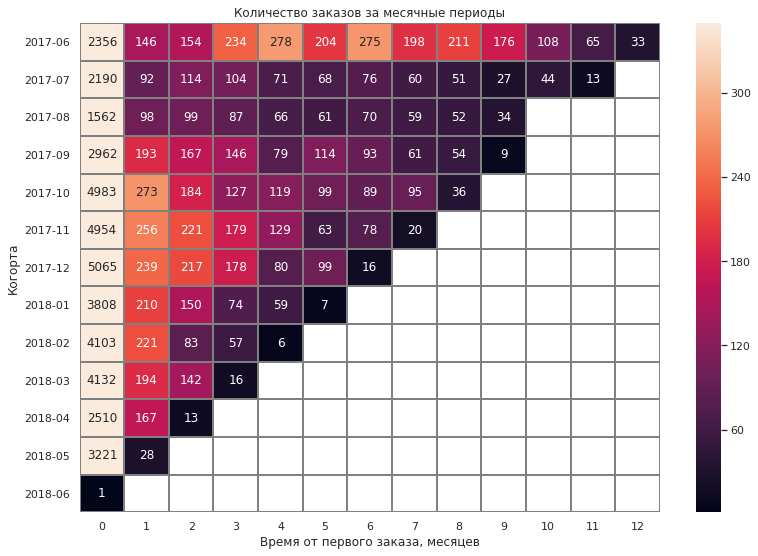

Количество покупок за периоды
                   uid
cohort_lifetime       
0                41847
1                 2117
2                 1544
3                 1202
4                  887
5                  715
6                  697
7                  493
8                  404
9                  246
10                 152
11                  78
12                  33


In [91]:
count_orders_by_period = orders.pivot_table(index = 'first_buy_month', 
                                      columns = 'cohort_lifetime',
                                      values = 'uid',
                                      aggfunc = 'count')
plt.figure(figsize=(13, 9))
plt.title('Количество заказов за месячные периоды')            
sns.heatmap(
    count_orders_by_period,
    annot=True,
    fmt='.0f', 
    linewidths=1,
    linecolor='gray', vmax=350)
plt.xlabel('Время от первого заказа, месяцев')
plt.ylabel('Когорта')
plt.show()
period_of_month = orders.groupby('cohort_lifetime').agg({'uid':'count'})
print('Количество покупок за периоды')
print(period_of_month)

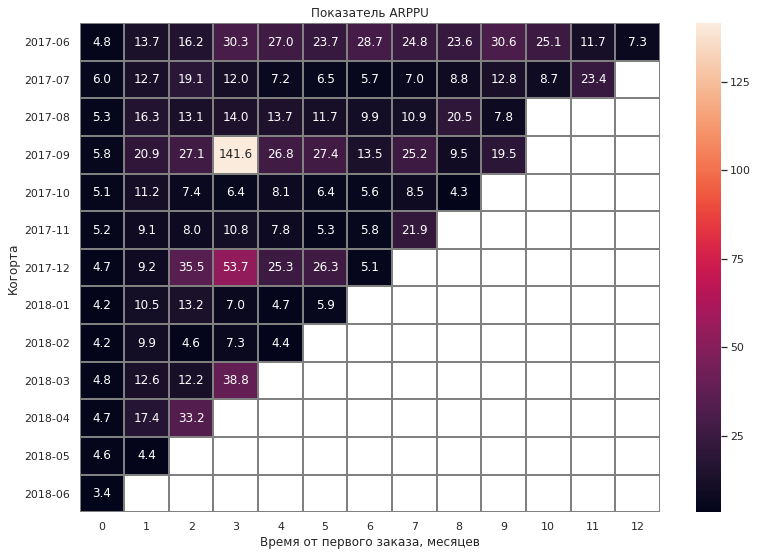

In [92]:
#считаем средний чек покупателя по когортам
revenue_per_user_by_cohorts = orders.groupby(['first_buy_month','cohort_lifetime']).agg({'uid':'nunique','revenue':'sum'}).reset_index()
revenue_per_user_by_cohorts.columns = ['first_buy_month','cohort_lifetime','count_of_users','sum_of_revenue']
revenue_per_user_by_cohorts['revenue_per_user'] = revenue_per_user_by_cohorts['sum_of_revenue']/revenue_per_user_by_cohorts['count_of_users']
revenue_per_user_by_cohorts = revenue_per_user_by_cohorts.pivot_table(index = 'first_buy_month', 
                                                                     columns = 'cohort_lifetime', 
                                                                     values = 'revenue_per_user', 
                                                                     aggfunc = 'mean')
plt.figure(figsize=(13, 9))
plt.title('Показатель ARPPU')
sns.heatmap(
revenue_per_user_by_cohorts,
annot=True,
fmt='.1f', 
linewidths=1,
linecolor='gray')
plt.xlabel('Время от первого заказа, месяцев')
plt.ylabel('Когорта')
plt.show()

In [93]:
#ищем средний чек продажи
count = len(orders)
sum_revenue = orders['revenue'].sum()
print('Средний чек продажи за всё время исследования {:.0f} рублей'.format(sum_revenue/count))

Средний чек продажи за всё время исследования 5 рублей


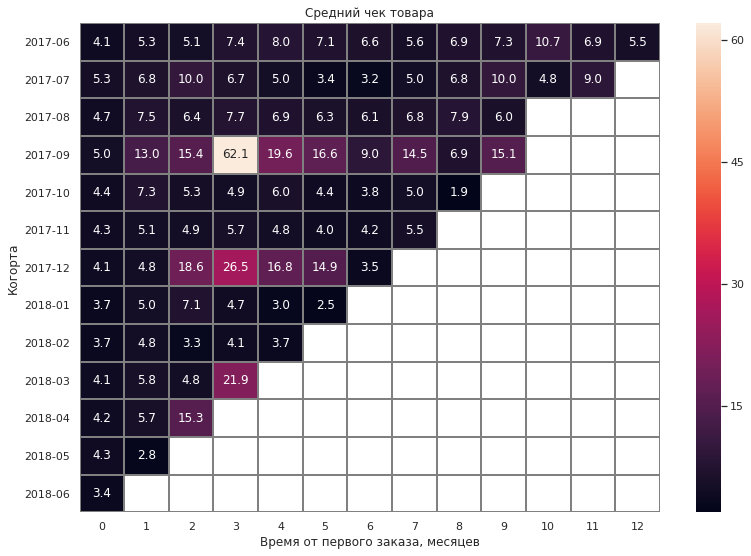

In [94]:
#считаем средний чек продажи по когортам
revenue_per_user_by_cohorts = orders.groupby(['first_buy_month','cohort_lifetime']).agg({'uid':'count','revenue':'sum'}).reset_index()
revenue_per_user_by_cohorts.columns = ['first_buy_month','cohort_lifetime','count_of_users','sum_of_revenue']
revenue_per_user_by_cohorts['revenue_per_user'] = revenue_per_user_by_cohorts['sum_of_revenue']/revenue_per_user_by_cohorts['count_of_users']
revenue_per_user_by_cohorts = revenue_per_user_by_cohorts.pivot_table(index = 'first_buy_month', 
                                                                     columns = 'cohort_lifetime', 
                                                                     values = 'revenue_per_user', 
                                                                     aggfunc = 'mean')
plt.figure(figsize=(13, 9))
plt.title('Средний чек товара')
sns.heatmap(
revenue_per_user_by_cohorts,
annot=True,
fmt='.1f', 
linewidths=1,
linecolor='gray')
plt.xlabel('Время от первого заказа, месяцев')
plt.ylabel('Когорта')
plt.show()

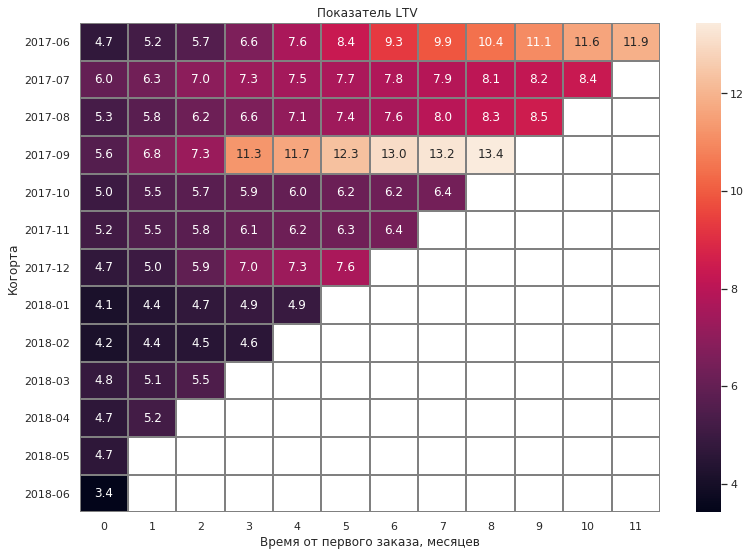

In [95]:
#считаем показатель LTV
first_order['first_buy_month'] = first_order['first_buy_date'].astype('datetime64[M]')
orders['buy_month'] = orders['buy_day'].astype('datetime64[M]')
orders['first_buy_month'] = orders['first_buy_month'].astype('datetime64[M]')

cohort_size = first_order.groupby('first_buy_month').agg({'uid':'nunique'}).reset_index()#количетсво новых пользователей
cohort_size.columns = ['first_buy_month','n_buyers']

cohorts_ltv = orders.groupby(['first_buy_month','buy_month']).agg({'revenue':'sum'}).reset_index()#выручка для когорт по месяцам

report = cohorts_ltv.merge(cohort_size, on = 'first_buy_month')
report['age'] = ((report['buy_month'] - report['first_buy_month'])/np.timedelta64(1,'M')).round()
report['age'] = report['age'].astype('int')#возраст когорты
report['ltv'] = report['revenue']/report['n_buyers']
report['first_buy_month'] = report['first_buy_month'].dt.strftime('%Y-%m')
LTV = report.pivot_table(index = 'first_buy_month',
                        columns = 'age',
                        values = 'ltv',
                        aggfunc = 'mean')
LTV = LTV.cumsum(axis=1).round(2)
plt.figure(figsize=(13, 9))
plt.title('Показатель LTV ')
sns.heatmap(LTV,annot=True,fmt='.1f', linewidths=1,linecolor='gray')
plt.xlabel('Время от первого заказа, месяцев')
plt.ylabel('Когорта')
plt.show()

### 4.2 Вывод 

- практически все пользователи совершают первые покупки в первый месяц после визита сайта, об этом говорят метрики: 1)**Churn Rate(у всех когорт отток пользователей > 90% после первого месяца** 2)**Retention Rate** 3)**Тепловая диаграмма 'Количество полльзователей, сеовршивших покупку первый раз'**
- были взяты периоды, величиной в 1 месяц с даты первых заказов. За первый период количесвто заказов равно **41847**, во второй количество снижается в 20 раз, а в последующие периоды равномерно уменьшается. Такой скачок вниз объясняется тем, что повторный заказ делают далеко не все пользователи, а первый заказ всегда будет учитываться в первом периоде
- средний чек продажи составил **5 рублей**, так же исследована зависимость среднего чека по когортам
- показатель **LTV** сентябрьской когорты 2017 года показатель превзошёл остальные, несмотря на дольшее существование некоторых других когорт. 

### 4.3 Маркетинг
*Исследуем, сколько денег потратили на маркетинг, сколько стоит стоило привлечение одного покупателя, на сколько окупились расходы(ROI)*

In [96]:
print('Всего на маркетинг потратили {:.0f} рублей'.format(costs['costs'].sum()))

Всего на маркетинг потратили 329132 рублей


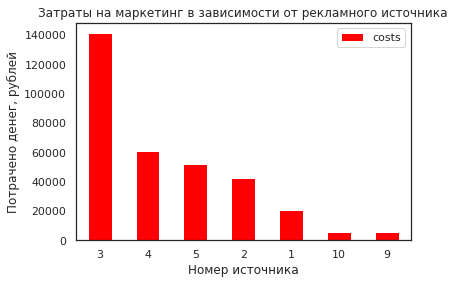

In [107]:
costs_source = costs.groupby('source_id').agg({'costs':'sum'}).reset_index().sort_values(by= 'costs', ascending = False)
costs_source.plot(x = 'source_id', y = 'costs',kind = 'bar',color = 'red')
plt.title('Затраты на маркетинг в зависимости от рекламного источника')
plt.xlabel('Номер источника')
plt.ylabel('Потрачено денег, рублей')
plt.xticks(rotation = 0)
plt.show()

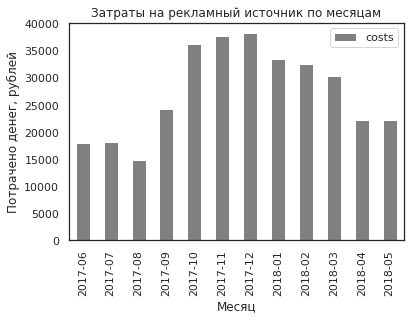

In [98]:
costs['dt_month'] = costs['dt'].astype('datetime64[M]').dt.strftime('%Y-%m')
costs_date = costs.groupby('dt_month').agg({'costs':'sum'}).reset_index()
costs_date.plot(x = 'dt_month', y = 'costs',kind = 'bar',color = 'gray')
plt.title('Затраты на рекламный источник по месяцам')
plt.ylabel('Потрачено денег, рублей')
plt.xlabel('Месяц')
plt.show()

source_id,1,2,3,4,5,9,10
dt_month,,,,,,,
2017-06,1126,2427,7732,3515,2616,285,314
2017-07,1073,2333,7674,3530,2998,303,330
2017-08,952,1811,6144,3217,2185,249,233
2017-09,1502,2986,9964,5192,3849,416,461
2017-10,2316,4845,15737,6421,5767,609,627
2017-11,2445,5248,17025,5389,6325,683,792
2017-12,2341,4898,16220,7680,5873,658,646
2018-01,2186,4158,14809,5833,5372,547,614
2018-02,2204,4474,14229,5712,5071,552,481


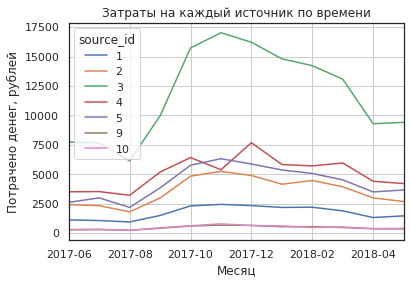

In [99]:
#ищем, сколько потратили всего на каждый источник по времени
costs_pivot = costs.pivot_table(index = 'dt_month', columns = 'source_id', values = 'costs', aggfunc = 'sum').round().\
astype('int')
display(costs_pivot)
costs_pivot.plot(grid = 'True')
plt.title('Затраты на каждый источник по времени')
plt.xlabel('Месяц')
plt.ylabel('Потрачено денег, рублей')
plt.show()

source_id,1,2,3,4,5,9,10
first_buy_month,,,,,,,
2017-06-01,5.54,8.96,13.47,8.43,7.11,2.77,3.61
2017-07-01,5.08,9.08,17.32,7.23,7.44,4.03,7.17
2017-08-01,6.56,11.84,21.18,9.78,6.60,2.96,6.29
2017-09-01,5.31,9.60,15.40,8.91,6.58,4.00,6.77
2017-10-01,5.66,9.73,15.22,5.81,6.21,3.50,3.28
2017-11-01,5.41,10.17,16.55,4.79,9.63,3.61,7.01
2017-12-01,5.11,9.58,14.20,5.96,7.95,3.99,8.18
2018-01-01,6.49,12.12,17.48,5.83,8.30,4.89,7.06
2018-02-01,6.39,11.81,14.64,5.49,7.55,4.75,3.82


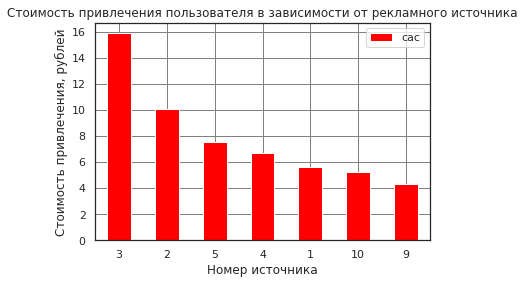

In [106]:
#ищем источник привлечения пользователя
source = visits.groupby('uid').agg({'source_id':'first'})
orders_with_source = orders.merge(source, on = 'uid')
orders_with_source_month = orders_with_source.groupby(['first_buy_month','source_id']).agg({'uid':'nunique'}).reset_index()

#ищем стоимость привлечения по источникам для каждой когорты
costs['dt_month'] = costs['dt'].astype('datetime64[M]')
costs_month = costs.groupby(['dt_month','source_id']).agg({'costs':'sum'})

marketing = orders_with_source_month.merge(costs_month, left_on = ['first_buy_month','source_id'], 
                                           right_on = ['dt_month','source_id'])
marketing['cac'] = marketing['costs']/marketing['uid']
marketing_pivot = marketing.pivot_table(index = 'first_buy_month', columns = 'source_id', values = 'cac').round(2)
display(marketing_pivot)
marketing.groupby('source_id').agg({'cac':'mean'}).sort_values(by = 'cac',ascending = False).plot(kind='bar',color = 'red')
plt.title('Стоимость привлечения пользователя в зависимости от рекламного источника')
plt.xlabel('Номер источника')
plt.ylabel('Стоимость привлечения, рублей')
plt.xticks(rotation = 0)
plt.grid(color='grey')
plt.show()

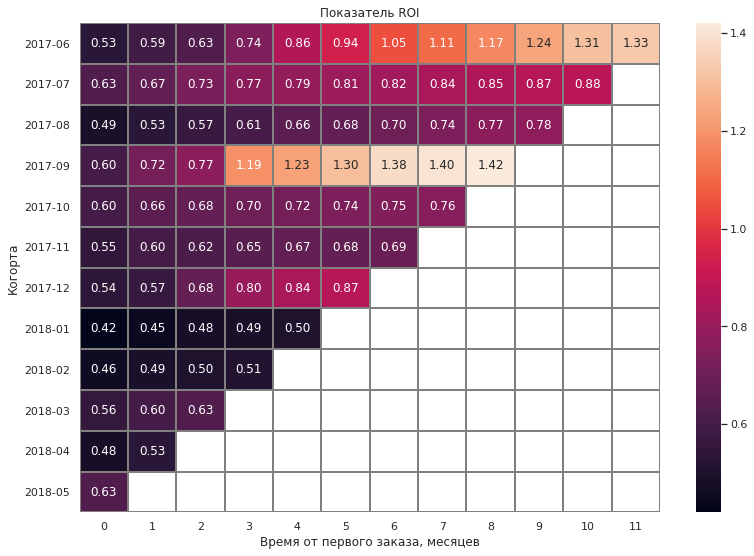

age
0     0.540816
1     0.581985
2     0.631069
3     0.719740
4     0.782946
5     0.859876
6     0.896819
7     0.969951
8     1.053871
9     0.964488
10    1.094658
11    1.333982
dtype: float64

In [101]:
report_new = pd.merge(report,costs_date, left_on = 'first_buy_month', right_on = 'dt_month')
report_new['cac'] = report_new['costs']/report_new['n_buyers']
report_new['roi'] = report_new['ltv']/report_new['cac']
report_new_pivot = report_new.pivot_table(index = 'first_buy_month',
                                         columns = 'age',
                                         values =  'roi',
                                         aggfunc = 'mean')
report_new_roi = report_new_pivot.cumsum(axis=1).round(2)
plt.figure(figsize=(13, 9))
plt.title('Показатель ROI')
sns.heatmap(report_new_roi,annot=True,fmt='.2f', linewidths=1,linecolor='gray')
plt.xlabel('Время от первого заказа, месяцев')
plt.ylabel('Когорта')
plt.show()

report_new_roi_avarage = report_new_pivot.cumsum(axis=1).mean(axis=0)
display(report_new_roi_avarage)


### 4.3 Вывод<a class="anchor" id="0-bullet">
- всего на маркетинг потратили **329 132 рубля**
- затраты на маркетинг окупились только у июньской и сентябрьской когорт 2017 года исходя из показателя `ROI` 